# Mediapipe Semantic Segmentation

Reverse Engineered by:

**Author:** [Rahmani Dibansa](https://web.facebook.com/rahmani.dibansa.GA)<br>
**Date created:** 2023/06/028<br>
**Last modified:** 2023/07/01<br>

## Prepare custom dataset

In [1]:
# Install kaggle to google colab
!pip install -q kaggle

In [2]:
# Mount the google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload the kaggle.json
# Make kaggle directory
!mkdir /kaggle
files.upload()
!ls -lha kaggle.json


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!pwd


# Download the lips segmentation dataset and
# Unzip the it
!kaggle datasets download -d remainaplomb/cihp-celebmaskhq-6class-256
!unzip /content/cihp-celebmaskhq-6class-256.zip

Streaming output truncated to the last 5000 lines.
  inflating: segmentation/image_6245.png  
  inflating: segmentation/image_62450.png  
  inflating: segmentation/image_62451.png  
  inflating: segmentation/image_62452.png  
  inflating: segmentation/image_62453.png  
  inflating: segmentation/image_62454.png  
  inflating: segmentation/image_62455.png  
  inflating: segmentation/image_62456.png  
  inflating: segmentation/image_62457.png  
  inflating: segmentation/image_62458.png  
  inflating: segmentation/image_62459.png  
  inflating: segmentation/image_6246.png  
  inflating: segmentation/image_62460.png  
  inflating: segmentation/image_62461.png  
  inflating: segmentation/image_62462.png  
  inflating: segmentation/image_62463.png  
  inflating: segmentation/image_62464.png  
  inflating: segmentation/image_62465.png  
  inflating: segmentation/image_62466.png  
  inflating: segmentation/image_62467.png  
  inflating: segmentation/image_62468.png  
  inflating: segmentation/i

In [4]:
image_dir = "/content/original"
mask_dir = "/content/segmentation"

In [5]:
import random
import glob
import os
import tensorflow as tf
from tensorflow.keras import backend

# Provide the directory paths for your custom dataset images and masks
image_dir = "/content/original"
mask_dir = "/content/segmentation"
image_size = 256

# def load_image(image_path, mask_path):
#     input_image = tf.io.read_file(image_path)
#     input_image = tf.image.decode_jpeg(input_image, channels=3)
#     input_image = tf.image.resize(input_image, (image_size, image_size))

#     input_mask = tf.io.read_file(mask_path)
#     input_mask = tf.image.decode_png(input_mask, channels=1)
#     input_mask = tf.image.resize(input_mask, (image_size, image_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     input_mask = tf.squeeze(input_mask, axis=-1)  # Remove the extra dimension
#     input_mask = tf.one_hot(input_mask, depth=6)

#     return input_image, input_mask

def load_image(image_path, mask_path):
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_jpeg(input_image, channels=3)
    input_image = tf.image.resize(input_image, (image_size, image_size))

    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)
    input_mask = tf.image.resize(input_mask, (image_size, image_size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.squeeze(input_mask, axis=-1)  # Remove the extra dimension
    input_mask = tf.one_hot(input_mask, depth=6, dtype=tf.float32)

    return input_image, input_mask


image_paths = glob.glob(image_dir + "/*.jpg")  # Modify the extension if needed

# Create mask paths by replacing the image directory and file format
mask_paths = [path.replace(image_dir, mask_dir).replace(".jpg", ".png") for path in image_paths]

# Shuffle the image and mask paths together
combined_paths = list(zip(image_paths, mask_paths))
random.shuffle(combined_paths)
image_paths, mask_paths = zip(*combined_paths)
print(f"100th image: {image_paths[100]} and mask: {mask_paths[100]}")
print(f"Length image: {len(image_paths)} and mask: {len(mask_paths)}")

train_size = int(0.8 * len(image_paths))  # 80% of the dataset for training

train_image_paths = tf.convert_to_tensor(image_paths[:train_size])
train_mask_paths = tf.convert_to_tensor(mask_paths[:train_size])

test_image_paths = tf.convert_to_tensor(image_paths[train_size:])
test_mask_paths = tf.convert_to_tensor(mask_paths[train_size:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))

auto = tf.data.AUTOTUNE
batch_size = 1

train_ds = (
    train_dataset
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    test_dataset
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)


100th image: /content/original/image_55738.jpg and mask: /content/segmentation/image_55738.png
Length image: 63280 and mask: 63280


In [6]:
# Print a sample batch from the training dataset
for images, masks in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

Image batch shape: (1, 256, 256, 3)
Mask batch shape: (1, 256, 256, 6)


In [7]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 6), dtype=tf.float32, name=None))>

In [8]:
print(f" 1000th image: {image_paths[1000]} and mask: {mask_paths[1000]}")
print(f" Length image: {len(image_paths)} and mask: {len(mask_paths)}")

 1000th image: /content/original/image_10775.jpg and mask: /content/segmentation/image_10775.png
 Length image: 63280 and mask: 63280


In [9]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

## Visualize dataset

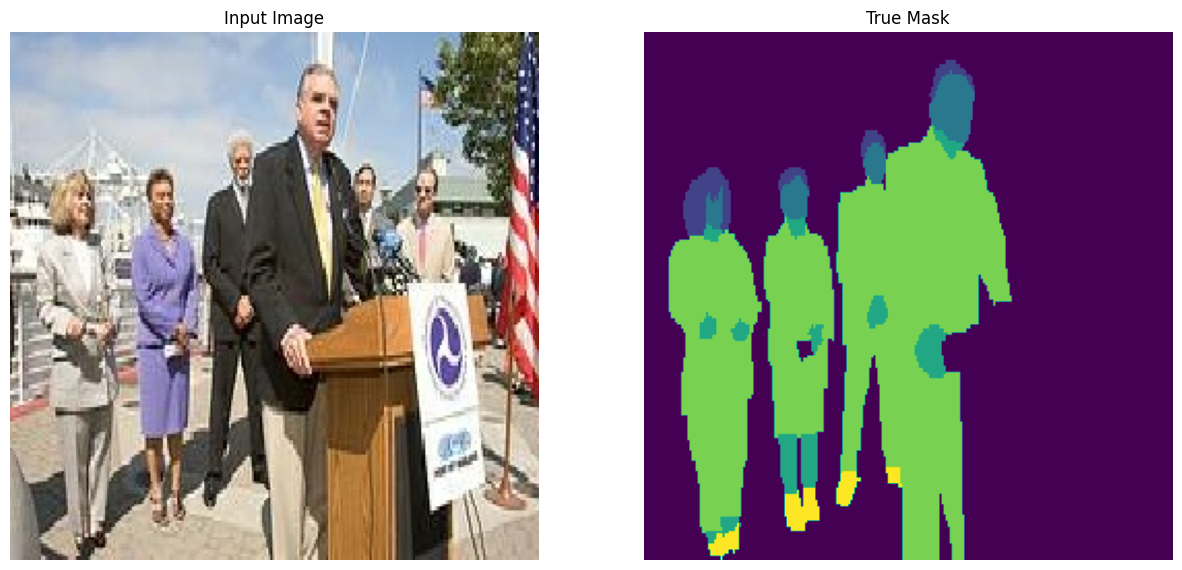

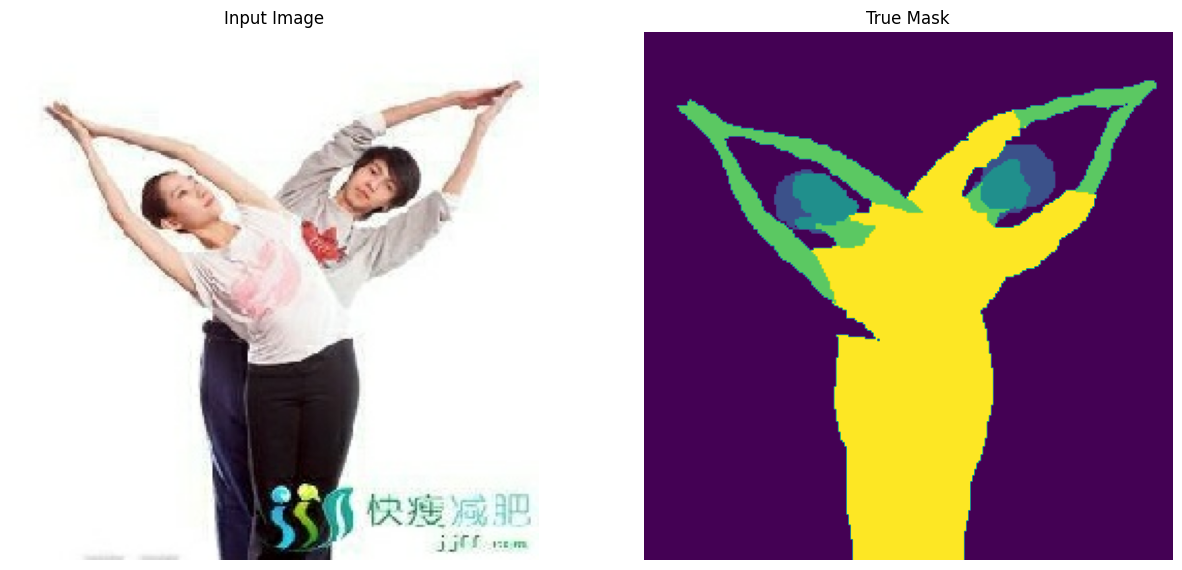

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        if i == 0:  # Input image
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:  # Mask image(s)
            if display_list[i].shape[-1] > 1:
                predicted_mask = tf.argmax(display_list[i], axis=-1)  # Extract predicted mask from one-hot encoding
                predicted_mask = tf.expand_dims(predicted_mask, -1)
                plt.imshow(tf.keras.utils.array_to_img(predicted_mask))
            else:
                plt.imshow(tf.keras.utils.array_to_img(display_list[i]))

        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples[0], samples[1]
    display([sample_image[0], sample_mask[0]])


## Custom model

In [11]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras import layers as L

from tensorflow.keras.utils import plot_model


def convBlock (priorNode, LAYER1= (96, (1,1), (1,1)), LAYER2=((3,3), (1,1)), LAYER3 = (64, (1,1), (1,1))):
  conv2d_1 = L.Conv2D(LAYER1[0], LAYER1[1], strides= LAYER1[2] , padding='same', use_bias=True, activation='relu')(priorNode)
  depth_conv2d_1 = L.DepthwiseConv2D(LAYER2[0], strides=LAYER2[1], padding='same', use_bias=True, activation='relu')(conv2d_1)
  conv2d_2 = L.Conv2D(LAYER3[0], LAYER3[1], strides=LAYER3[2], padding='same', use_bias=True)(depth_conv2d_1)
  return conv2d_2

def reshapeTransposeBlock(priorNode, RESHAPE=(8, 4, 8, 512), TRANSPOSE_PERM=[0, 2, 1, 3]):
    print("HEY")
    # print(priorNode.shape)
    print(RESHAPE)
    batch_size = tf.shape(priorNode)[0]
    reshape = tf.reshape(priorNode, RESHAPE)
    transpose = tf.transpose(reshape, perm=TRANSPOSE_PERM)
    print(transpose.shape)
    return transpose


def transposeReshapeBlock (priorNode, RESHAPE=(8, 4, 8, 512), TRANSPOSE_PERM=[0, 2, 1, 3]):
  transpose = tf.transpose(priorNode, perm=TRANSPOSE_PERM)
  batch_size = tf.shape(transpose)[0]
  reshape = tf.reshape(transpose, RESHAPE)
  return reshape

def largeBlock(priorNode, MUL=128):
  # Block 2-1
  block_2_1 = tf.multiply(priorNode, priorNode)  # Multiply with priorNode itself
  block_2_1 = tf.add(block_2_1, block_2_1)  # Add the result with itself

  # Block 2-2
  block_2_2 = L.Conv2D(1, (1, 1), strides=(1, 1), padding='same', use_bias=True)(block_2_1)

  batch_size = tf.shape(block_2_2)[0]
  if MUL == 128:
    block_2_2 = tf.reshape(block_2_2, (batch_size, 16, 1, 64))
  elif MUL == 192:
    block_2_2 = tf.reshape(block_2_2, (batch_size, 16, 1, 16))

  block_2_2 = L.Softmax(axis=-1)(block_2_2)

  batch_size = tf.shape(block_2_2)[0]
  if MUL == 128:
    block_2_2 = tf.reshape(block_2_2, (batch_size, 16, 64, 1))
  elif MUL == 192:
    block_2_2 = tf.reshape(block_2_2, (batch_size, 16, 16, 1))

  # Block 2-3
  block_2_3 = L.Conv2D(MUL, (1, 1), strides=(1, 1), padding='same', use_bias=True)(block_2_1)
  block_2_3 = L.Multiply()([block_2_2, block_2_3])
  block_2_3 = L.Lambda(lambda x: tf.reduce_sum(x, axis=2, keepdims=True))(block_2_3)

  # Block 2-4
  block_2_4 = L.Conv2D(MUL, (1, 1), strides=(1, 1), padding='same', use_bias=True, activation='relu')(block_2_1)
  block_2_4 = L.Multiply()([block_2_3, block_2_4])
  block_2_4 = L.Conv2D(MUL, (1, 1), strides=(1, 1), padding='same', use_bias=True)(block_2_4)
  block_2_4 = L.Add()([block_2_4, priorNode])  # <-- Corrected typo: block2 -> priorNode

  # Block 2-5
  block_2_5 = L.Conv2D(MUL*2, (1, 1), strides=(1, 1), padding='same', use_bias=True)(block_2_1)
  block_2_5 = L.Conv2D(MUL, (1, 1), strides=(1, 1), padding='same', use_bias=True)(block_2_5)

  # Output
  return L.Add()([block_2_5, block_2_4])


# BUILD MODEL
def build_model(input_shape, classes = 6, bs = 4):
  # Input layer
  inputs = L.Input(input_shape)
  x = L.Conv2D(16, (3, 3), strides=(2, 2), padding='same', use_bias=True, activation='relu')(inputs)

  # Block 1 (CONV)
  x1 = convBlock(x, LAYER1= (96, (1,1), (1,1)), LAYER2=((3,3), (1,1)), LAYER3 = (64, (1,1), (1,1)))
  x1 = convBlock(x1, LAYER1= (384, (1,1), (1,1)), LAYER2=((3,3), (2,2)), LAYER3 = (128, (1,1), (1,1)))

  x1_1 = convBlock(x1, LAYER1= (768, (1,1), (1,1)), LAYER2=((3,3), (1,1)), LAYER3 = (128, (1,1), (1,1)))
  output1 = L.Add(name= "output1")([x1_1, x1])
  # batch_size = tf.shape(output1)[0]
  # output1 = tf.reshape(output1, (bs, 64, 64, 128))

  # Block 2
  x2 = convBlock(output1, LAYER1= (768, (1,1), (1,1)), LAYER2=((3,3), (2,2)), LAYER3 = (256, (1,1), (1,1)))
  x2 = L.Conv2D(128, (3,3), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x2)
  x2 = L.Conv2D(128, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x2)
  bs = tf.shape(x2)
  x2 = reshapeTransposeBlock(x2, RESHAPE= (8, 4, 8, 512), TRANSPOSE_PERM=[0, 2, 1, 3])
  output2 = reshapeTransposeBlock(x2, RESHAPE= (1, 64, 16, 128), TRANSPOSE_PERM=[0, 2, 1, 3])

  # Block 3
  x3 = largeBlock(output2)
  x3 = largeBlock(x3)

  x3 = transposeReshapeBlock(x3, RESHAPE= (8, 8, 4, 512), TRANSPOSE_PERM=[0, 2, 1, 3])
  x3 = transposeReshapeBlock(x3, RESHAPE= (1, 32, 32, 128), TRANSPOSE_PERM=[0, 2, 1, 3])
  output3 = L.Conv2D(256, (1, 1), strides=(1, 1), padding='same', use_bias=True, name="output3")(x3)

  # Block 4
  x4 = convBlock(output3, LAYER1= (1536, (1,1), (1,1)), LAYER2=((3,3), (2,2)), LAYER3 = (384, (1,1), (1,1)))
  x4 = L.Conv2D(192, (3,3), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x4)
  x4 = L.Conv2D(192, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x4)
  x4.shape

  x4 = reshapeTransposeBlock(x4, RESHAPE= (4, 4, 4, 768), TRANSPOSE_PERM=[0, 2, 1, 3])
  x4 = reshapeTransposeBlock(x4, RESHAPE= (1, 16, 16, 192), TRANSPOSE_PERM=[0, 2, 1, 3])
  # x4.shape

  x4 = largeBlock(x4, MUL=192)
  x4 = largeBlock(x4, MUL=192)
  x4 = largeBlock(x4, MUL=192)
  x4 = largeBlock(x4, MUL=192)

  x4 = transposeReshapeBlock(x4, RESHAPE= (4, 4, 4, 768), TRANSPOSE_PERM=[0, 2, 1, 3])
  x4 = transposeReshapeBlock(x4, RESHAPE= (1, 16, 16, 192), TRANSPOSE_PERM=[0, 2, 1, 3])
  x4 = L.Conv2D(384, (1,1), strides= (1,1) , padding='same', use_bias=True)(x4)
  x4 = L.DepthwiseConv2D((1,1), strides=(1,1), padding='same', use_bias=True)(x4)
  output4 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True, name= "output4")(x4)

  # Block 5
  x5 = L.DepthwiseConv2D((1,1), strides=(1,1), padding='same', use_bias=True)(output3)
  x5 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x5)

  x5_output4 = tf.image.resize(output4, size=(32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  output5 = L.Add(name= "output5")([x5, x5_output4])

  # Block 6
  x6 = L.DepthwiseConv2D((1,1), strides=(1,1), padding='same', use_bias=True)(output1)
  x6 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x6)

  x6_output5 = tf.image.resize(output5, size=(64, 64), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  output6 = L.Add(name= "output6")([x6, x6_output5])

  # Block 7
  x7 = L.DepthwiseConv2D((1,1), strides=(1,1), padding='same', use_bias=True)(x)
  x7 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x7)

  x7_output6 = tf.image.resize(output6, size=(128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  output7 = L.Add(name= "output7")([x7, x7_output6])

  # Block 8 (No longer need resize nearest neighbor)
  x8 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output7)
  x8 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x8)

  x8_output6 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output6)
  x8_output6 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x8_output6)
  x8_output6 = tf.image.resize(x8_output6, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)
  output8 = L.Add(name= "output8")([x8, x8_output6])

  # Block 9
  x9 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output8)
  x9 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x9)

  x9_output5 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output5)
  x9_output5 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x9_output5)
  x9_output5 = tf.image.resize(x9_output5, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)
  output9 = L.Add(name= "output9")([x9, x9_output5])

  # Block 10
  x10 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output9)
  x10 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x10)

  x10_output4 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True)(output4)
  x10_output4 = L.Conv2D(64, (1,1), strides= (1,1) , padding='same', use_bias=True)(x10_output4)
  x10_output4 = tf.image.resize(x10_output4, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)
  output10 = L.Add(name= "output10")([x10, x10_output4])

  # Block 11 (Head)
  x11 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True, activation='relu')(output10)
  x11 = L.Conv2D(32, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x11)

  x11 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True, activation='relu')(x11)
  x11 = L.Conv2D(32, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x11)

  x11 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True, activation='relu')(x11)
  x11 = L.Conv2D(32, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x11)

  x11 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True, activation='relu')(x11)
  x11 = L.Conv2D(32, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x11)

  x11 = L.DepthwiseConv2D((3,3), strides=(1,1), padding='same', use_bias=True, activation='relu')(x11)
  x11 = L.Conv2D(32, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='relu')(x11)

  x11 = L.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', use_bias=True)(x11)

  #output11 = L.Conv2D(NUM_CLASSES, (1,1), strides= (1,1) , padding='same', use_bias=True, activation='sigmoid')(x11)
  # outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)
  output11 = L.Conv2D(NUM_CLASSES, 1, padding='same', activation='softmax')(x11)


  # Build model
  return tf.keras.Model(inputs=inputs, outputs=output11)


INPUT_SHAPE = (256, 256, 3)
NUM_CLASSES = 6
BATCH_SIZE = 1
model = build_model(INPUT_SHAPE, NUM_CLASSES, BATCH_SIZE)

HEY
(8, 4, 8, 512)
(8, 8, 4, 512)
HEY
(1, 64, 16, 128)
(1, 16, 64, 128)
HEY
(4, 4, 4, 768)
(4, 4, 4, 768)
HEY
(1, 16, 16, 192)
(1, 16, 16, 192)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 96  1632        ['conv2d[0][0]']                 
                                )                                                             

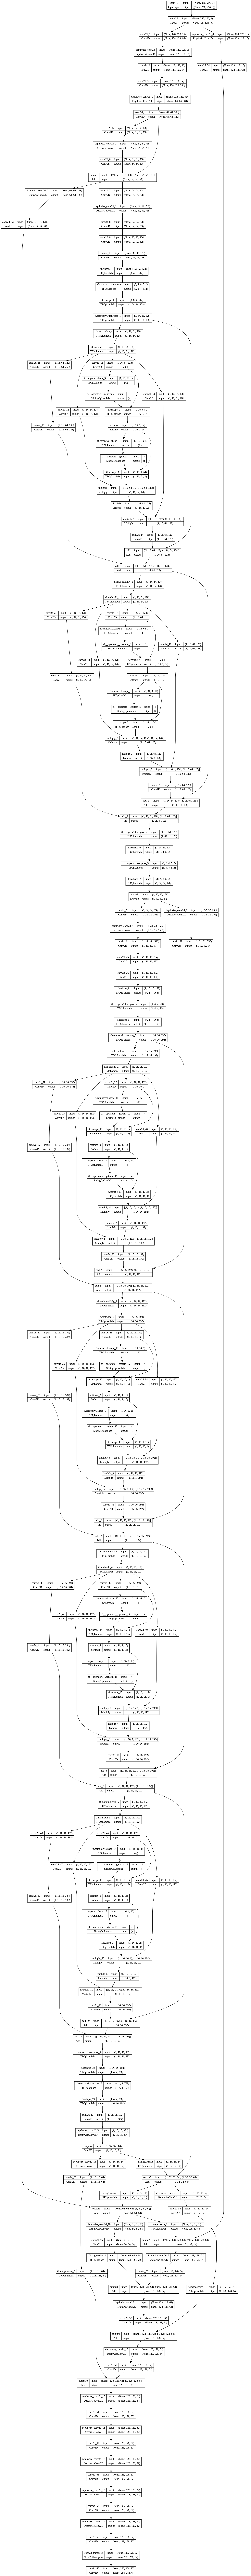

In [13]:
# Save model architecture plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Compile the model

In [10]:
# lr = 0.000001
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])
lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])
model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),
        metrics=['accuracy']
)


In [14]:
lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.load_weights( "/content/drive/MyDrive/Reverse_Engineer_Mediapipe/Segmentation/Test4/class6.ckpt")
model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),
        metrics=['accuracy']
)

In [ ]:
#model.summary()

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

## Prediction callback to monitor training progress

In [15]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    mask_values = [0, 1, 2, 3, 4, 5]  # Adjust the mask values based on your dataset
    pred_mask = tf.gather(mask_values, pred_mask)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)  # Expand dimensions along the channel axis
    # print(" PRED MASK SHAPE: ", pred_mask.shape)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample[0], sample[1]
            # masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images)
            # print(" PRED MASK SHAPE: ", pred_masks[0].shape)
            # images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], pred_masks[0]])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )
# for samples in train_ds.take(2):
#     sample_image, sample_mask = samples[0], samples[1]
#     display([sample_image[0], sample_mask[0]])

class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


1/1 [==============================] - 11s 11s/step


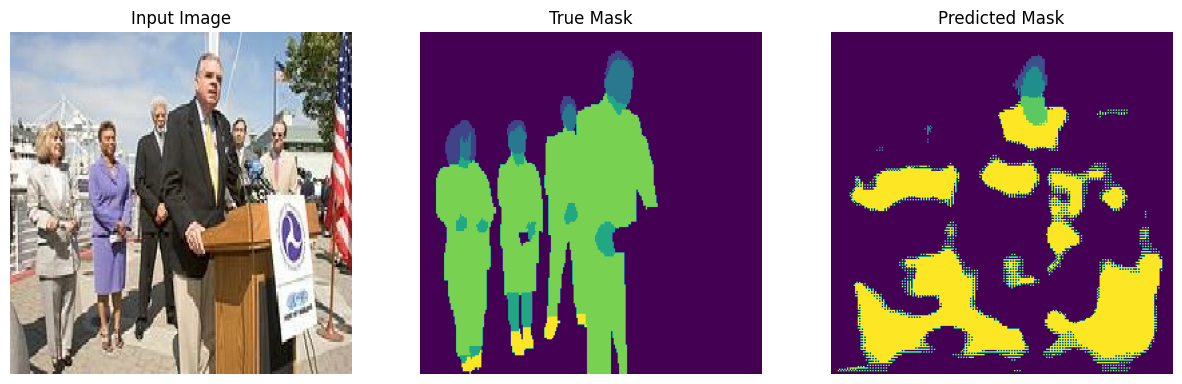

In [16]:
show_predictions(train_ds)

1/1 [==============================] - 0s 27ms/step


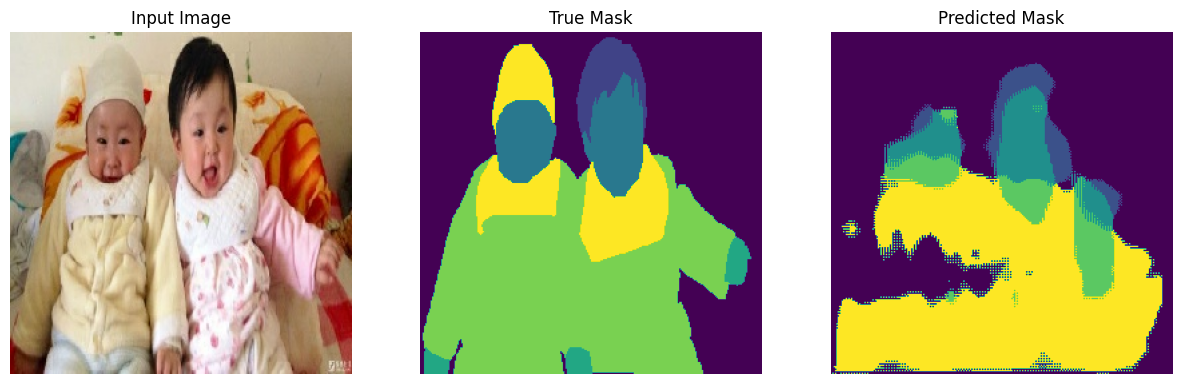

In [17]:
show_predictions(test_ds)

## Train model

In [18]:
checkpoint_path = "/content/drive/MyDrive/Reverse_Engineer_Mediapipe/Segmentation/Test4/class6.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint( checkpoint_path,
                                                save_weights_only=True,
                                                verbose= 1)

Epoch 1/20
1/1 [==============================] - 0s 27ms/step


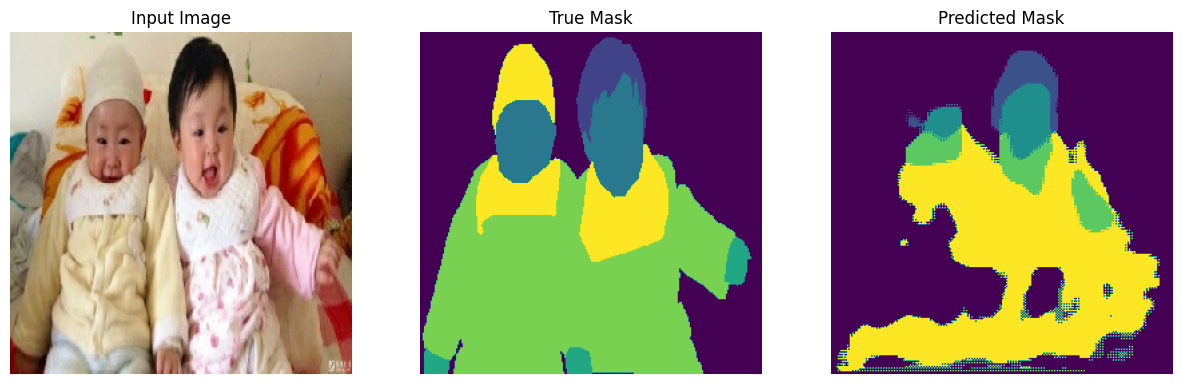


Sample Prediction after epoch 1


Epoch 1: saving model to /content/drive/MyDrive/Reverse_Engineer_Mediapipe/Segmentation/Test4/class6.ckpt
50624/50624 [==============================] - 2987s 55ms/step - loss: 0.6598 - accuracy: 0.7508 - val_loss: 0.6068 - val_accuracy: 0.7721
Epoch 2/20
1/1 [==============================] - 0s 27ms/step


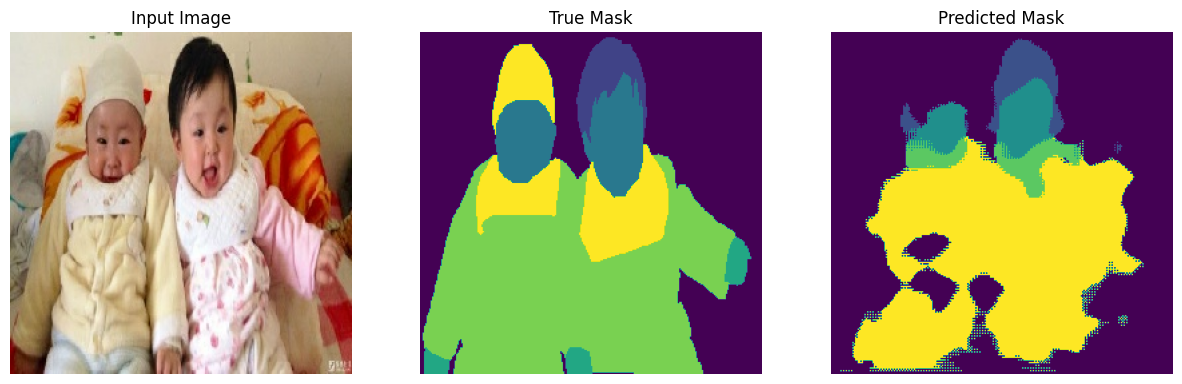


Sample Prediction after epoch 2


Epoch 2: saving model to /content/drive/MyDrive/Reverse_Engineer_Mediapipe/Segmentation/Test4/class6.ckpt
50624/50624 [==============================] - 2978s 59ms/step - loss: 195.5516 - accuracy: 0.7742 - val_loss: 0.5685 - val_accuracy: 0.7889
Epoch 3/20
10272/50624 [=====>........................] - ETA: 39:47 - loss: 0.5655 - accuracy: 0.7896

In [ ]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 20

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds),cp_callback],
    epochs=epochs,
)

In [ ]:
# Test 1
# loss: 2 - accuracy: 0.2923
# loss: 1.7919 - accuracy: 0.2906

# Test 2
# loss: nan - accuracy: 0.4326 --- 0.4480

# Test 4
# loss: 1.6360 - accuracy: 0.4326 --- 0.4545

In [ ]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 20

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds), cp_callback],
    epochs=epochs,
)

## Inference

We perform inference on a few samples from the test set.

1/1 [==============================] - 14s 14s/step


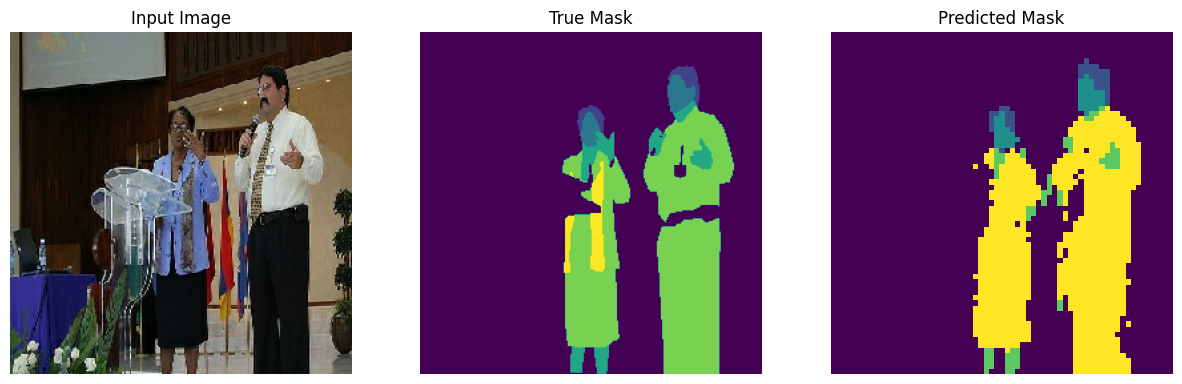

1/1 [==============================] - 4s 4s/step


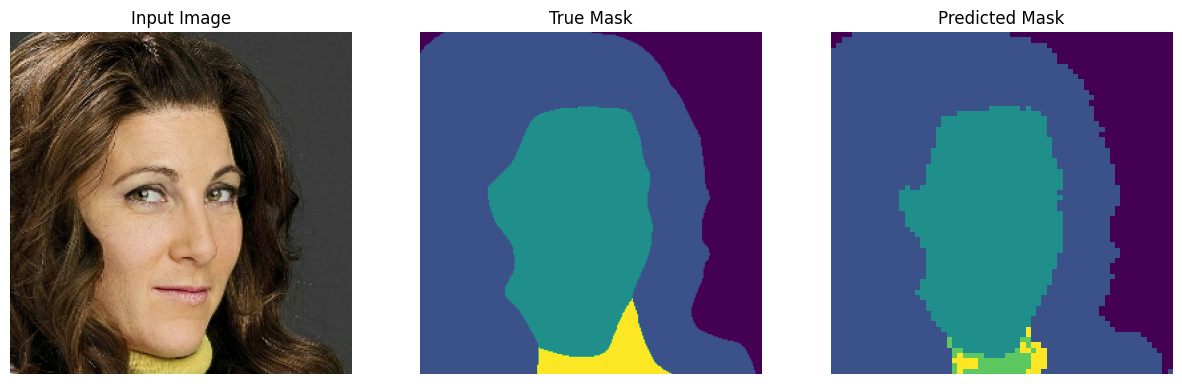

1/1 [==============================] - 4s 4s/step


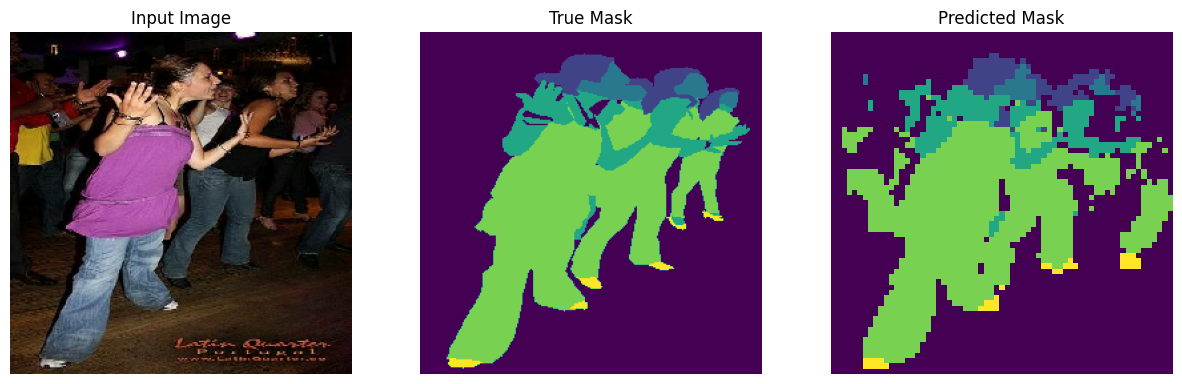

1/1 [==============================] - 3s 3s/step


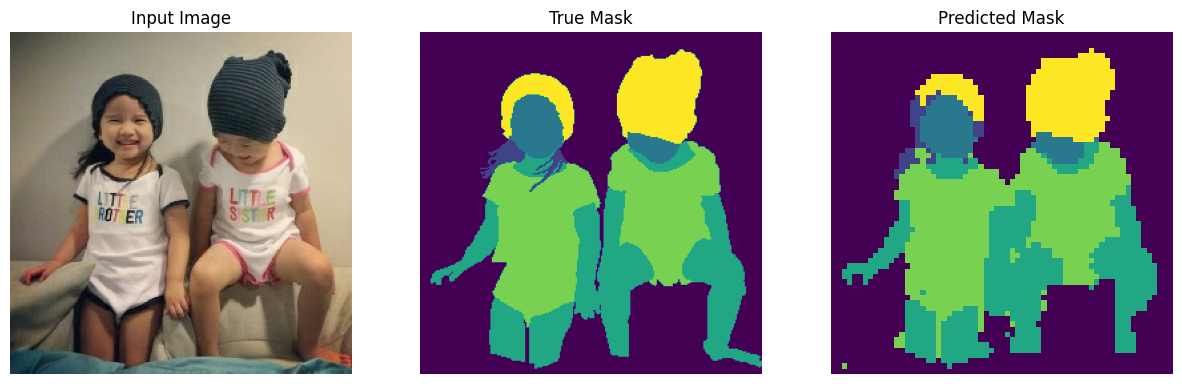

1/1 [==============================] - 3s 3s/step


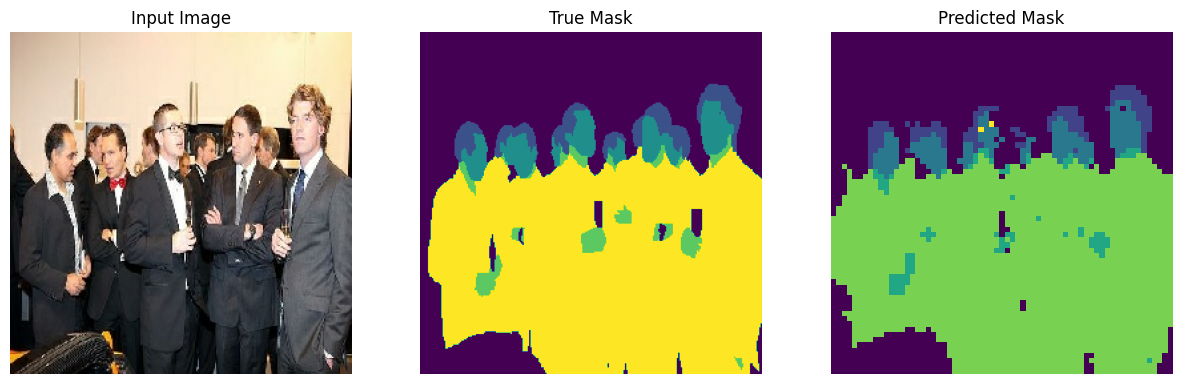

In [ ]:
show_predictions(test_ds, 5)

## Conclusion

sadasdasdas

# Save Model

In [ ]:
import tensorflow as tf
#from transformers import TFSegformerForSemanticSegmentation

# Load the trained model
#model = TFSegformerForSemanticSegmentation.from_pretrained('RemainAplomb/class6-MITb5')

# Create a sample input tensor
sample_input = tf.ones((1, 256, 256, 3), dtype=tf.float32)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
#                                        tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/Keras_Segformer_257/6class_MITb0_257.tflite"
TF_LITE_MODEL_FILE_NAME = "meh10.tflite"
# Save the TensorFlow Lite model
with open(TF_LITE_MODEL_FILE_NAME, 'wb') as f:
    f.write(tflite_model)


## Test Mediapipe

In [ ]:
import tensorflow as tf

# Load the TFLite model
model_path = "225_s63739_loss0-4087.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get information about the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print the details of the output tensor(s)
for output in output_details:
    print("Output Name:", output["name"])
    print("Output Shape:", output["shape"])
    print("Output Activation Function:", output["activation"])


Output Name: ResizeBilinear_2
Output Shape: [  1 225 225   9]


KeyError: ignored